In [ ]:
# Loading the Google drive/folder into Colab
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Import data from Excel sheet
import pandas as pd
#df = pd.read_excel('/content/drive/My Drive/ADNI_komplett/ADNI combined.xlsx', sheet_name='sample')
df = pd.read_excel('/content/drive/My Drive/AIBL_mwrp1_OASIS50-50/AIBL_cleaned_excel.xlsx', sheet_name='Sheet1')
#print(df)
sid = df['RID']
grp = df['DXCURREN']
age = df['age']
sex = df['Sex (1=female)']
tiv = df['Total']
field = df['field_strength']
grpbin = (grp > 1) # 1=CN, ...

In [ ]:
import re
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

In [ ]:
# Scan for nifti file names
import glob
dataFiles = sorted_alphanumeric(glob.glob('/content/drive/My Drive/AIBL_mwrp1_OASIS50-50/*.nii.gz'))
numfiles = len(dataFiles)
print('Found ', str(numfiles), ' nifti files')

Found  621  nifti files


In [ ]:
# Actually load nifti files into array
import nibabel as nib
import numpy as np
from sklearn import linear_model
# 1. Dimension: Die Nummer des Samples
# 2. Dimension: Die Bildzeile
# 3. Dimension: Die Bildspalte
# 4. Dimension: Die Bildtiefe
# 5. Dimension: Die Farbkanäle
print('Loading files...')
# define FOV to reduce required memory size
x_range_from = 13; x_range_to = 107
y_range_from = 15; y_range_to = 126 # full brain: 15:126 # old reduced field of view: 54:86
z_range_from = 12; z_range_to = 100
images = np.zeros((numfiles, z_range_to-z_range_from, x_range_to-x_range_from, y_range_to-y_range_from, 1), dtype=np.float32) # numfiles× z × x × y ×1; avoid 64bit types
#print(images.shape)

Loading files...


In [ ]:
for i in range(numfiles):   # for loop over files and load
  if (i % 50 == 0):
    print('Loading file %d of %d' % (i+1, numfiles))
  img = nib.load(dataFiles[i])
  img = img.get_data()[x_range_from:x_range_to, y_range_from:y_range_to, z_range_from:z_range_to]
  img = np.transpose(img, (2, 0, 1)) # reorder dimensions to match coronal view z*x*y in MRIcron etc.
  #img = np.fliplr(img) # flip upside down and
  #img = np.flipud(img) # left/right to match MRIcroN views when plotted directly
  #img = np.flip(img, 2) # flip front/back
  img = np.flip(img) # flip all positions
  #print(img.shape)
  images[i, :,:,:, 0] = np.nan_to_num(img)
print('Successfully loaded files')
print('Image array size: ', images.shape)

Loading file 1 of 621


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  """


Loading file 51 of 621
Loading file 101 of 621
Loading file 151 of 621
Loading file 201 of 621
Loading file 251 of 621
Loading file 301 of 621
Loading file 351 of 621
Loading file 401 of 621
Loading file 451 of 621
Loading file 501 of 621
Loading file 551 of 621
Loading file 601 of 621
Successfully loaded files
Image array size:  (621, 88, 94, 111, 1)


In [ ]:
# save original images array to disk
#assert False # uncomment to really override existing file on drive
import h5py
hf = h5py.File('/content/drive/My Drive/AIBL_wb.hdf5', 'w')
hf.create_dataset('images', data=images, compression='gzip')
hf.close()
#!ls -lh /content/drive/My\ Drive/ADNI_komplett

In [ ]:
# Load original images from disk
import h5py
import numpy as np
hf = h5py.File('/content/drive/My Drive/AIBL_wb.hdf5', 'r')
hf.keys # read keys
images_orig = np.array(hf.get('images'))
hf.close()
testdat_orig = images_orig
print(testdat_orig.shape)


(621, 88, 94, 111, 1)


In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
# Match covariate information
import re
debug = False
cov_idx = [-1] * numfiles # list; array: np.full((numfiles, 1), -1, dtype=int)
print('Matching covariates for loaded files ...')
for i,id in enumerate(sid):
  p = [j for j,x in enumerate(dataFiles) if re.search('_%d_MR' % id, x)] # translate ID numbers to four-digit numbers, get both index and filename
  if len(p)==0:
    if debug: print('Did not find %04d' % id) # did not find Excel sheet subject ID in loaded file selection
  else:
    if debug: print('Found %04d in %s: %s' % (id, p[0], dataFiles[p[0]]))
    cov_idx[p[0]] = i # store Excel index i for data file index p[0]
print('Checking for scans not found in Excel sheet: ', sum(x<0 for x in cov_idx))

labels = pd.DataFrame({'Group':grpbin}).iloc[cov_idx, :]
grps = pd.DataFrame({'Group':grp, 'RID':sid}).iloc[cov_idx, :]

Matching covariates for loaded files ...
Checking for scans not found in Excel sheet:  0


In [ ]:
# Perform regression-based covariates cleaning
from sklearn import linear_model
from pandas import DataFrame

covariates = DataFrame({'Age':age, 'Sex':sex, 'TIV':tiv, 'FieldStrength':field}).iloc[cov_idx, :]
print("Covariates data frame size : ", covariates.shape)
print(covariates.head())
#print(label.head())
covariates = covariates.to_numpy(dtype=np.float32) # convert dataframe to nparray with 32bit types

covCN = covariates[labels['Group'] == 0] # only controls as reference group to estimate effect of covariates
print("Controls covariates data frame size : ", covCN.shape)
lm = linear_model.LinearRegression()

for k in range(images.shape[3]):
  print('Processing depth slice ', str(k+1), ' of ', str(images.shape[3]))
  for j in range(images.shape[2]):
    for i in range(images.shape[1]):
      if any(images[:, i, j, k, 0] != 0):
        tmpdat = images[labels['Group'] == 0, i, j, k, 0]
        lm.fit(covCN, tmpdat) # estimate model coefficients (intercept added automatically)
        pred = lm.predict(covariates) # calculate prediction for all subjects
        images[:, i, j, k, 0] = images[:, i, j, k, 0] - pred # % subtract effect of covariates from original values (=calculate residuals)

Covariates data frame size :  (621, 4)
   Age  Sex      TIV  FieldStrength
0   70    0  1677.28            3.0
1   68    1  1212.39            3.0
2   84    1  1215.42            3.0
3   73    0  1529.43            3.0
4   80    0  1260.88            3.0
Controls covariates data frame size :  (455, 4)
Processing depth slice  1  of  111
Processing depth slice  2  of  111
Processing depth slice  3  of  111
Processing depth slice  4  of  111
Processing depth slice  5  of  111
Processing depth slice  6  of  111
Processing depth slice  7  of  111
Processing depth slice  8  of  111
Processing depth slice  9  of  111
Processing depth slice  10  of  111
Processing depth slice  11  of  111
Processing depth slice  12  of  111
Processing depth slice  13  of  111
Processing depth slice  14  of  111
Processing depth slice  15  of  111
Processing depth slice  16  of  111
Processing depth slice  17  of  111
Processing depth slice  18  of  111
Processing depth slice  19  of  111
Processing depth slice

In [ ]:
#assert False # uncomment to really override existing file on drive
# Save residualized data to disk
import h5py
hf = h5py.File('/content/drive/My Drive/AIBL_residuals_wb.hdf5', 'w')
hf.create_dataset('labels', data=labels, compression='gzip')
hf.create_dataset('images', data=images, compression='gzip')
# don't store Strings or String arrays in HDF5 containers as this is problematic
hf.close()

In [ ]:
# Load residualized data from disk
import h5py
import numpy as np
from pandas import DataFrame
hf = h5py.File('/content/drive/My Drive/AIBL_residuals_wb.hdf5', 'r')
hf.keys # read keys
labels = np.array(hf.get('labels')) # note: was of data frame type before
images = np.array(hf.get('images'))
hf.close()
testdat = images
print(testdat.shape)

(621, 88, 94, 111, 1)


displaying residual image  /content/drive/My Drive/AIBL_mwrp1_OASIS50-50/mwrp1AIBL_2_MR_MPRAGE_ADNI_confirmed__br_raw_20141030141855909_126_S235328_I450385.nii.gz


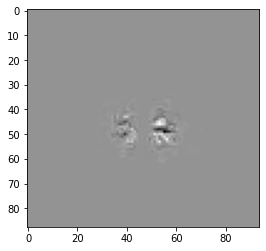

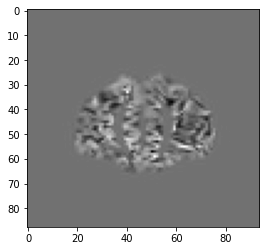

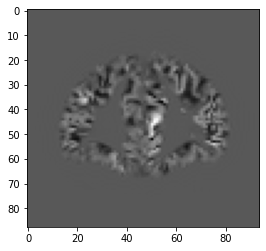

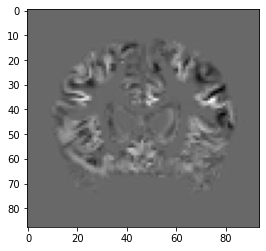

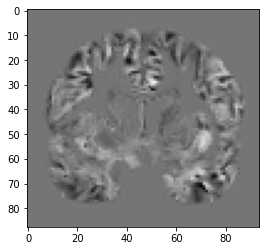

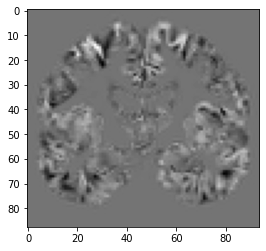

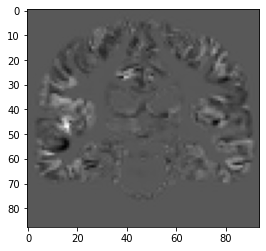

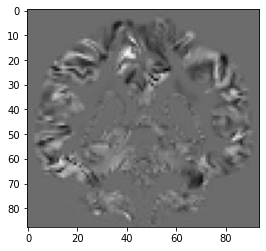

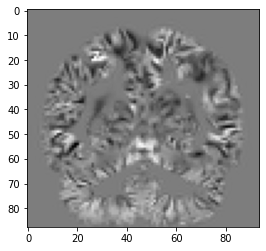

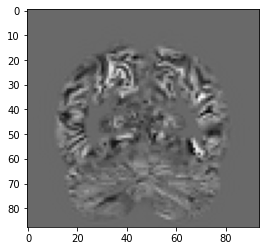

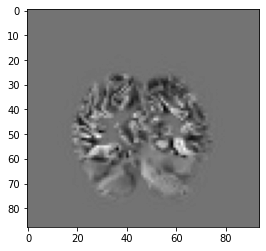

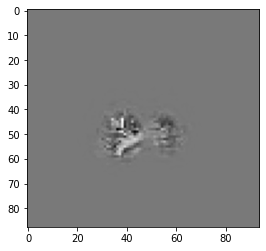

In [ ]:
# Display a single scan (residuals)
from matplotlib import pyplot as plt
#import numpy as np
test_img = images[0, :,:,:, 0]
ma = np.max(test_img)
mi = np.min(test_img)
test_img = (test_img - mi) / (ma - mi) # normalising to (0-1) and then normalising to 0 mean and 1 std
#test_img = (test_img - test_img.mean())/test_img.std() # normalizing by mean and sd
print('displaying residual image ', dataFiles[0])
for i in range(test_img.shape[2]):
  if (i % 10 == 0): # only display each fifth slice
    plt.figure()
    a = test_img[:,:,i]
    plt.imshow(a, cmap='gray')

In [ ]:
from keras.utils import to_categorical
labels = to_categorical(np.asarray(labels))

# Load CNN model from disk
from keras.models import load_model
mymodel = load_model('/content/drive/My Drive/AIBL_mwrp1_OASIS50-50/models relevance map dice coeff exp/wb_5cnn_fold4.hdf5',compile=False)
#mymodel = load_model('/content/wb_3cnn_no_residual_2xDA.hdf5',compile=False)
mymodel.summary()
#%whos
from keras.optimizers import Adam
mymodel.compile(loss='categorical_crossentropy', optimizer = Adam(lr = 0.001 ,decay=0.01), metrics=['accuracy'])

scores = mymodel.evaluate(testdat, labels) 
print("Test %s: %.2f%%" % (mymodel.metrics_names[1], scores[1]*100))

Using TensorFlow backend.






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.






_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_16 (Conv3D)           (None, 88, 94, 111, 20)   560       
_________________________________________________________________
batch_normalization_16 (Batc (None, 88, 94, 111, 20)   80        
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 44, 47, 55, 20)    0         
_________________________________________________________________
activation_16 (Activation)   (None, 44, 47, 55, 20)    0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 44, 47, 55, 20)    10820     
_________________________________________________________________
batch_normalization_17 (Batc (None, 44, 47, 55, 20)    80        
_________________

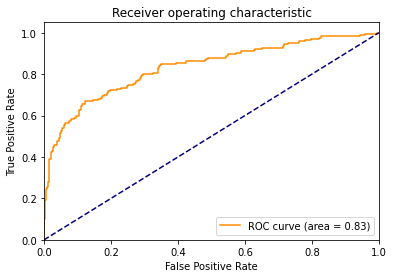

In [ ]:
# calculate area under the curve
# AUC as optimization function during training: https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
pred = mymodel.predict(testdat)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2): # classes dummy vector: 0 - CN, 1 - MCI/AD
    fpr[i], tpr[i], _ = roc_curve(labels[:, i], pred[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr[1], tpr[1], color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
idx = np.asarray(range(numfiles))
testgrps = grps.iloc[idx, :]
#print(testgrps) # prints diagnosis and RID

print('Distribution of diagnoses in holdout test data: [1=CN, 2=MCI, 3=AD]')
print(testgrps.Group.value_counts())
from sklearn.metrics import roc_curve, auc
# redo AUC for binary comparison: AD vs. CN and MCI vs. CN
for i in [2,3]:
  grpi = np.equal(testgrps.Group.to_numpy(dtype=np.int), np.ones((testgrps.shape[0],), dtype=np.int)*i)
  grp1 = np.equal(testgrps.Group.to_numpy(dtype=np.int), np.ones((testgrps.shape[0],), dtype=np.int))
  grpidx = np.logical_or(grpi, grp1)
  fpr[i], tpr[i], _ = roc_curve(labels[grpidx, 1], pred[grpidx, 1])
  roc_auc[i] = auc(fpr[i], tpr[i])

print('AUC for MCI vs. CN = %0.2f' % roc_auc[2])
print('AUC for AD vs. CN = %0.2f' % roc_auc[3])

Distribution of diagnoses in holdout test data: [1=CN, 2=MCI, 3=AD]
1    455
2     99
3     67
Name: Group, dtype: int64
AUC for MCI vs. CN = 0.77
AUC for AD vs. CN = 0.93


In [ ]:
!pip install innvestigate

     |████████████████████████████████| 102kB 2.6MB/s 
     |████████████████████████████████| 317kB 8.7MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [ ]:
import innvestigate
import innvestigate.utils as iutils
import numpy as np
from matplotlib import pyplot as plt

model_wo_softmax = iutils.keras.graph.model_wo_softmax(mymodel)
#model_wo_softmax.summary()

subj_idx = 69
test_img = testdat[subj_idx]
test_orig = testdat_orig[subj_idx]
print('test image for subject of binary group: %d' % labels[subj_idx, 1]) # first col will indicate CN, second col indicates MCI/AD
print('test image for subject of ADNI diagnosis: %d [1-CN, 2-MCI, 3-AD]' % testgrps.Group.to_numpy(dtype=np.int)[subj_idx])
print('test subject ID %s' % testgrps.RID.to_numpy(dtype=np.int)[subj_idx])

test_img = np.reshape(test_img, (1,)+ test_img.shape) # add first subj index again to mimic original array structure
test_orig = np.reshape(test_orig, (1,)+ test_orig.shape) # add first subj index again to mimic original array structure

# see https://github.com/albermax/innvestigate/blob/master/examples/notebooks/imagenet_compare_methods.ipynb for a list of alternative methods
methods = [ # tuple with method,     params,                  label

            ("lrp.alpha_1_beta_0",   {"neuron_selection_mode":"index"},  "LRP-alpha1beta0"),
]

# create analyzer
analyzers = []
for method in methods:
    
#analyzer = innvestigate.create_analyzer("deep_taylor.bounded", model_wo_softmax, **params )
  analyzer = innvestigate.create_analyzer(method[0], model_wo_softmax, **method[1])
  # Some analyzers require training.
  analyzer.fit(test_img, batch_size=30, verbose=1)
  analyzers.append(analyzer)

test image for subject of binary group: 1
test image for subject of ADNI diagnosis: 3 [1-CN, 2-MCI, 3-AD]
test subject ID 112


/usr/local/lib/python3.6/dist-packages/innvestigate/analyzer/base.py:130: RuntimeWarning: This analyzer does not need to be trained. Still fit() is called.
  " Still fit() is called.", RuntimeWarning)


In [ ]:
from PIL import Image
from matplotlib import cm

# map: overlay
# rescale_threshold: max value to be plotted, larger values will be set to this value; 
#   corresponding to vmax in plt.imshow; vmin=-vmax used here
# alpha_threshold: absolute intensities below this value are removed from the plot; 
#   applied to given map rescaled to [-1, 1] so that negative activation is kept if present
# overlay_alpha: alpha value for final result image, applied to all pixels being displayed
def prepare_overlay( map, rescale_threshold = 1.4, alpha_treshold = 0.5, overlay_alpha = 0.5): #rescale_threshold = 3 - default
  #map = a[:,:, row * jump]
  map[map >= rescale_threshold] = rescale_threshold   #map[map >= 100] = 100 # thresholding
  map[map <= -rescale_threshold] = -rescale_threshold #map[map <= -100] = -100
  alpha_mask = map/rescale_threshold # range -1 to 1 float
  map = map/rescale_threshold/2 + 0.5 # range 0-1 float
  map = np.uint8(cm.jet(map) * 255) # cm translates range 0 - 255 uint to rgba array
  alpha_mask[np.abs(alpha_mask) < alpha_treshold] = 0 # completely hide low values
  alpha_mask[np.abs(alpha_mask) >= alpha_treshold] = overlay_alpha # final transparency of visible content
  map[:,:,3] = np.uint8(alpha_mask * 255) # replace alpha channel (fourth dim) with calculated values
  #rgba_map = Image.fromarray(map)
  #plt.figure()
  #plt.imshow((test_orig[0, :,:, row*jump, 0]), cmap='gray')
  #plt.imshow(rgba_map)
  return map


1875.1475


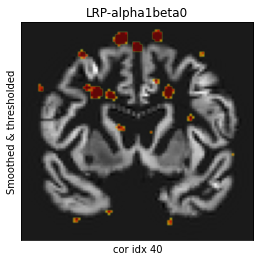

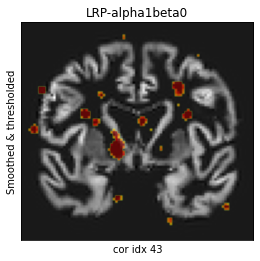

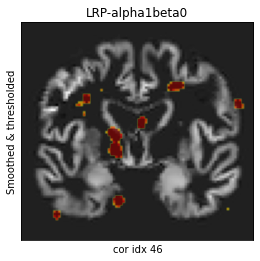

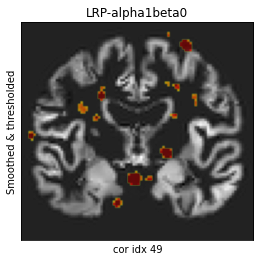

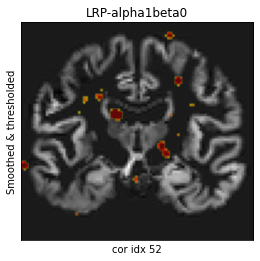

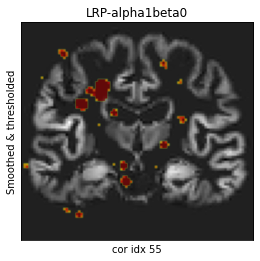

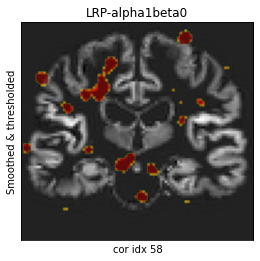

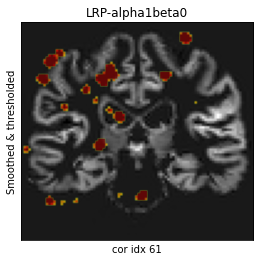

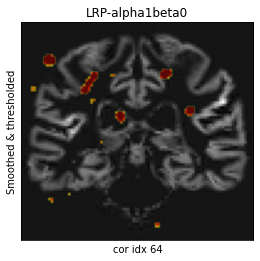

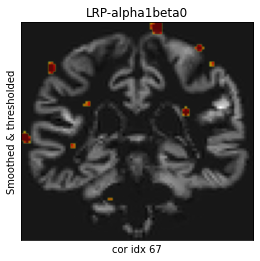

In [ ]:
import scipy
# display smoothed maps
for method,analyzer in zip(methods, analyzers):
  a = np.reshape(analyzer.analyze(test_img, neuron_selection=1), test_img.shape[1:4])
  np.clip(a,a_min=0,a_max=None,out=a)
  a = scipy.ndimage.filters.gaussian_filter(a, sigma=0.8) # smooth activity image
  scale = np.quantile(np.absolute(a), 0.99)
  if scale==0:
      scale = max(np.amax(a))
  #print(scale)
  a = (a/scale) # rescale range
  print(np.amax(a))
  #a = a.astype(int)
  #plt.figure()
  #plt.hist(np.reshape(a, -1), bins=50, range=(-10,10))
  #plt.gca().set_yscale('log')
  #plt.gca().set(title='Frequency Histogram', ylabel='Frequency');

  slices = [40,43,46,49,52,55,58,61,64,67] # for whole brain 32 slices

  #images_per_row = 10 # only ten linearly scliced out of 111 depth
  #jump = (a.shape[2] // images_per_row)
  
  #for row in range(images_per_row):
  for row in slices:
    plt.figure()
      
    #plt.imshow((test_orig[0, :,:, row*jump, 0]), cmap='gray') #coronal
    plt.imshow((test_orig[0, :,:, row, 0]), cmap='gray') #for whole brain

    #plt.imshow(prepare_overlay((a[:,:, row * jump]), alpha_treshold = 0.4, overlay_alpha = 0.7)) #coronal
    plt.imshow(prepare_overlay((a[:,:, row]), alpha_treshold = 0.4, overlay_alpha = 0.7)) #for whole brain

    #plt.colorbar()
    plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
    #plt.gca().set(title=method[2], ylabel='Smoothed & thresholded', xlabel=('cor idx %d' % (row * jump)));
    plt.gca().set(title=method[2], ylabel='Smoothed & thresholded', xlabel=('cor idx %d' % (row)));



In [ ]:
def confusion_matrix_n(Y_true, Y_pred):
    plt.figure()
    import seaborn as sns
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    confusion_matrix = pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])
    cmn = confusion_matrix.astype('float') / (confusion_matrix.sum(axis=1)[:,np.newaxis])
    sns.heatmap(cmn, annot=True,cmap='Blues',fmt='.2f',vmin=0,vmax=1)
    return plt.show()

def class_report(Y_true, Y_pred):
    from sklearn.metrics import classification_report
    target_names = ['CN','MCI/AD']
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    print(classification_report(Y_true, Y_pred, target_names=target_names))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


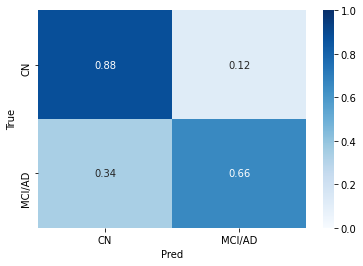

              precision    recall  f1-score   support

          CN       0.88      0.88      0.88       455
      MCI/AD       0.66      0.66      0.66       166

    accuracy                           0.82       621
   macro avg       0.77      0.77      0.77       621
weighted avg       0.82      0.82      0.82       621



In [ ]:
ACTIVITIES = {
    0: 'CN',
    1: 'MCI/AD',
}
confusion_matrix_n(labels, pred)
class_report(labels, pred)

In [ ]:
pred[:,1]

array([0.13440669, 0.51886684, 0.09027497, 0.09546873, 0.91918147,
       0.06704389, 0.12651284, 0.07528599, 0.11783256, 0.6693554 ,
       0.96879476, 0.04865421, 0.05890226, 0.27924603, 0.04382928,
       0.17072028, 0.12564367, 0.20475982, 0.0723597 , 0.7755193 ,
       0.01707022, 0.04960429, 0.02633588, 0.8623679 , 0.6943258 ,
       0.06185833, 0.0487432 , 0.08405594, 0.21577051, 0.02524148,
       0.21573718, 0.13219123, 0.36699903, 0.11366191, 0.39199358,
       0.02602245, 0.5510747 , 0.19247189, 0.72571117, 0.24076265,
       0.07393789, 0.02076828, 0.05149352, 0.05263894, 0.04643831,
       0.03066356, 0.6034989 , 0.228658  , 0.1041531 , 0.08054246,
       0.02140267, 0.37603837, 0.01910038, 0.10140926, 0.09166122,
       0.9241285 , 0.9168952 , 0.7684489 , 0.04357899, 0.24639189,
       0.12966754, 0.9027216 , 0.13661462, 0.24474584, 0.48439205,
       0.07616918, 0.9274178 , 0.8038265 , 0.9342046 , 0.9265041 ,
       0.6280787 , 0.02905049, 0.19440253, 0.02823178, 0.18368

In [ ]:
import nibabel as nib

# define FOV to reduce required memory size
x_range_from = 13; x_range_to = 107
y_range_from = 15; y_range_to = 126 # full brain: 15:126  32 slice 54:86
z_range_from = 12; z_range_to = 100

data_overlay = sorted(glob.glob('/content/drive/My Drive/Hippocampal_Activations_latest/*.nii.gz'))
hippo_overlay = np.zeros((len(data_overlay), z_range_to-z_range_from, x_range_to-x_range_from, y_range_to-y_range_from, 1), dtype=np.float32) # numfiles× z × x × y ×1; avoid 64bit types

for i in range(len(data_overlay)):   
    img = nib.load(data_overlay[i])
    img = img.get_data()[x_range_from:x_range_to, y_range_from:y_range_to, z_range_from:z_range_to]
    img = np.transpose(img, (2, 0, 1)) # reorder dimensions to match coronal view z*x*y in MRIcron etc.
    img = np.flip(img) # flip all positions
    hippo_overlay[i, :,:,:, 0] = np.nan_to_num(img)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  del sys.path[0]


In [ ]:
###### check which file corresponds to hippo l,r and both with indexes 0,1 and 2#####
data_overlay[0]

'/content/drive/My Drive/Hippocampal_Activations_latest/GM0,5_wH-O_thr25_HippBoth.nii.gz'

In [ ]:
#hippos
hippo_both = np.zeros((z_range_to-z_range_from, x_range_to-x_range_from, y_range_to-y_range_from), dtype=np.float32)
hippo_left = np.zeros((z_range_to-z_range_from, x_range_to-x_range_from, y_range_to-y_range_from), dtype=np.float32)
hippo_right = np.zeros((z_range_to-z_range_from, x_range_to-x_range_from, y_range_to-y_range_from), dtype=np.float32)
hippo_both[:,:,:] = hippo_overlay[0,:,:,:,0]
hippo_left[:,:,:] = hippo_overlay[1,:,:,:,0]
hippo_right[:,:,:] = hippo_overlay[2,:,:,:,0]

In [ ]:
print("subject_ID Sum_activation_of_right_hippocampal_volume Sum_activation_of_left_hippocampal_volume Sum_activation_of_both_hippocampal_volume ")
#subj_idx = 9 # good visualizations for subjects idx 4 (AD), 5 (AD), 6 (LMCI), 8 (AD), 10 (LMCI), 27 (CN)
for indx in range(len(grps)):
    test_img = images[indx]
    #test_orig = images_orig[indx]
    #print('test image for subject of binary group: %d' % test_Y[subj_idx, 1]) # first col will indicate CN, second col indicates MCI/AD
    #print('test image for subject of ADNI diagnosis: %d [1-CN, 3-LMCI, 4-AD]' % testgrps.Group.to_numpy(dtype=np.int)[subj_idx])
    
    ####print('test subject ID %s' % grps.RID.to_numpy(dtype=np.int)[indx])

    test_img = np.reshape(test_img, (1,)+ test_img.shape) # add first subj index again to mimic original array structure
    #test_orig = np.reshape(test_orig, (1,)+ test_orig.shape) # add first subj index again to mimic original array structure

    #for method,analyzer in zip(methods, analyzers):
    a = np.reshape(analyzer.analyze(test_img,neuron_selection=1), test_img.shape[1:4])
    #"""
    np.clip(a,a_min=0,a_max=None, out=a)
    a = scipy.ndimage.filters.gaussian_filter(a, sigma=0.8) # smooth activity image
    scale = np.quantile(np.absolute(a), 0.99)
    if scale==0:
        scale = max(np.amax(a))   #scale = max(-np.amin(a), np.amax(a))
            #print(scale)
    a = (a/scale)
    #"""
    #a = (a - np.min(a)) / (np.max(a) - np.min(a)) 
    overlay_act_both = hippo_both * a
    overlay_act_l = hippo_left * a
    overlay_act_r = hippo_right * a
        
    print(grps.RID.to_numpy(dtype=np.int)[indx],np.sum(overlay_act_r),np.sum(overlay_act_l),np.sum(overlay_act_both))

        #print(grps.RID.to_numpy(dtype=np.int)[indx],np.mean(overlay_act_r[hippo_right>0]),np.sum(overlay_act_r[hippo_right>0]),np.mean(overlay_act_l[hippo_left>0]),np.sum(overlay_act_l[hippo_left>0]),np.mean(overlay_act_both[hippo_both>0]),np.sum(overlay_act_both[hippo_both>0]))
        #print('subject ID %s : Mean activation of left hippocampal volume %f : Sum activation of left hippocampal volume %f' % (grps.RID.to_numpy(dtype=np.int)[indx],np.mean(overlay_act_l[hippo_left>0]),np.sum(overlay_act_l[hippo_left>0])))
        #print('subject ID %s : Mean activation of both hippocampal volume %f : Sum activation of both hippocampal volume %f' % (grps.RID.to_numpy(dtype=np.int)[indx],np.mean(overlay_act_both[hippo_both>0]),np.sum(overlay_act_both[hippo_both>0])))

subject_ID Sum_activation_of_right_hippocampal_volume Sum_activation_of_left_hippocampal_volume Sum_activation_of_both_hippocampal_volume 
2 0.0007262244 0.02558716 0.026313383
3 3.7903476 0.23713891 4.0274863
4 0.12826937 0.08235413 0.21062347
5 8.659106e-05 0.0017378305 0.0018244215
12 255.78908 801.9646 1057.7535
14 0.0056827553 1.0028241 1.0085069
15 0.0023257528 4.9694757 4.971801
16 0.015169206 0.70256925 0.7177384
17 0.012363762 0.019628877 0.03199264
18 0.008396517 0.04256978 0.050966293
19 442.84772 399.77347 842.6213
20 0.0034251616 2.621691 2.6251159
21 0.7770408 0.038068097 0.81510884
22 0.110864915 0.0015844717 0.11244938
23 0.062259775 0.17080039 0.23306017
24 0.004260018 0.016664939 0.020924956
25 0.5983924 0.16268255 0.76107496
26 0.07475721 0.23570149 0.3104587
27 0.1972026 4.901203 5.0984054
28 0.043261398 5.8246373e-05 0.043319646
29 0.00043145014 34.68698 34.687416
31 0.002568828 0.14276473 0.14533356
33 0.100245915 0.7847092 0.88495517
36 8.4791354e-05 0.0025517733

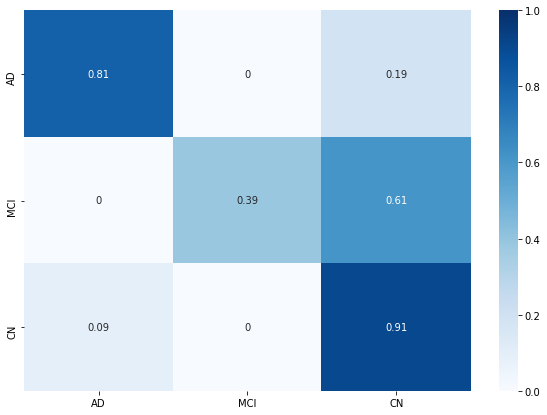

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
lst = ['AD','MCI','CN']
array = [[0.81,0,0.19], 
        [0,0.39,0.61], 
        [0.09,0,0.91]]
df_cm = pd.DataFrame(array, index = [i for i in lst],
                  columns = [i for i in lst])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap='Blues',vmin=0,vmax=1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


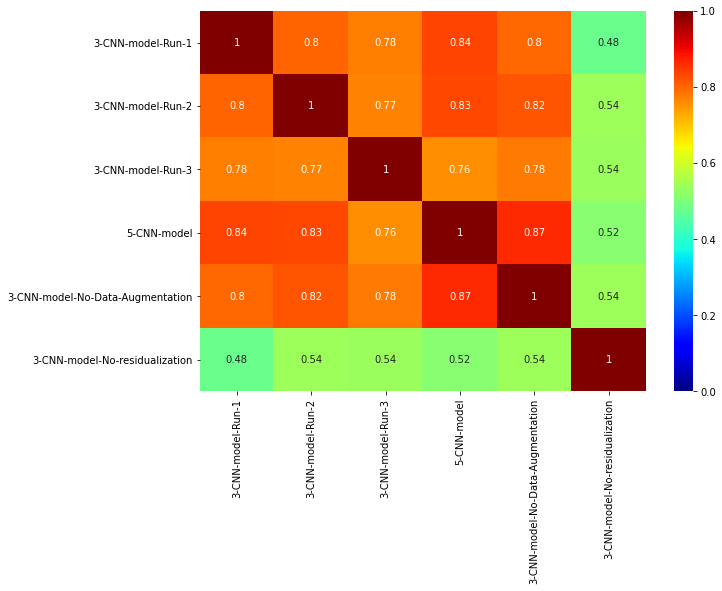

In [ ]:
#hippocampal region activations dice similarity coeff 32 slice

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
lst = ['3-CNN-model-Run-1','3-CNN-model-Run-2','3-CNN-model-Run-3','5-CNN-model','3-CNN-model-No-Data-Augmentation','3-CNN-model-No-residualization']
array = [[1.0,0.8042620363062352,0.7756552643269657,0.8397163120567376,0.797045101088647,0.4787976382179281], 
         [0.8042620363062352,1.0,0.7718335619570188,0.8323657474600871,0.817384370015949,0.5391884380211228], 
         [0.7756552643269657,0.7718335619570188,1.0,0.7594015365952285,0.7793258426966292,0.5382585751978892],
         [0.8397163120567376,0.8323657474600871,0.7594015365952285,1.0,0.8654259126700071,0.5151079136690647],
         [0.797045101088647,0.817384370015949,0.7793258426966292,0.8654259126700071,1.0,0.5400108873162766],
         [0.4787976382179281,0.5391884380211228,0.5382585751978892,0.5151079136690647,0.5400108873162766,1.0]]
df_cm = pd.DataFrame(array, index = [i for i in lst],
                  columns = [i for i in lst])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap='jet',vmin=0,vmax=1)

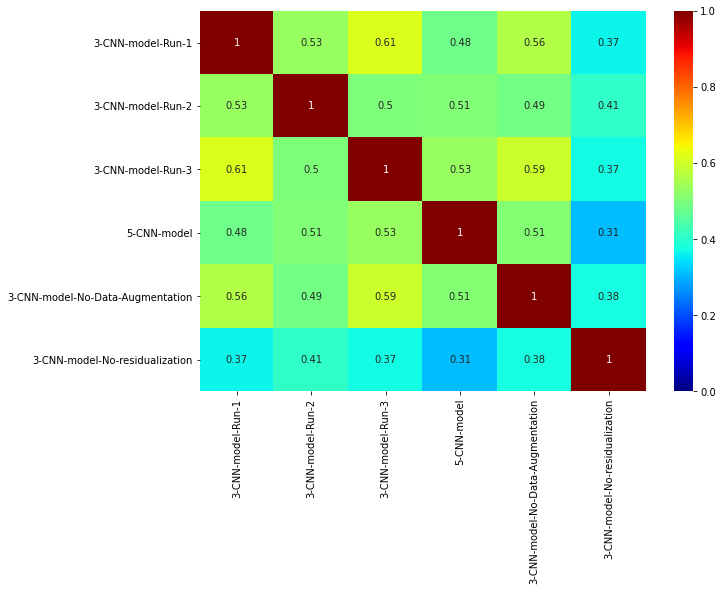

In [ ]:
#whole brain region activations dice similarity coeff 32 slice

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
lst = ['3-CNN-model-Run-1','3-CNN-model-Run-2','3-CNN-model-Run-3','5-CNN-model','3-CNN-model-No-Data-Augmentation','3-CNN-model-No-residualization']
array = [[1.0,0.5318147506771458,0.6140426915158739,0.4809633517801582,0.5640147523709168,0.3650535598957753], 
         [0.5318147506771458,1.0,0.5017028224865874,0.5073142310173335,0.48845470692717585,0.4091472167056649], 
         [0.6140426915158739,0.5017028224865874,1.0,0.532668853772758,0.5937744495361573,0.3725632444829281],
         [0.4809633517801582,0.5073142310173335,0.532668853772758,1.0,0.5078706528370958,0.31136524896698525],
         [0.5640147523709168,0.48845470692717585,0.5937744495361573,0.5078706528370958,1.0,0.37610508280982297],
         [0.3650535598957753,0.4091472167056649,0.3725632444829281,0.31136524896698525,0.37610508280982297,1.0]]
df_cm = pd.DataFrame(array, index = [i for i in lst],
                  columns = [i for i in lst])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap='jet',vmin=0,vmax=1)

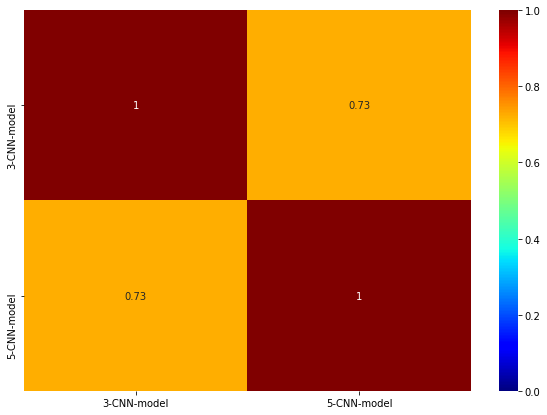

In [ ]:
#hippocampal region activations dice similarity coeff wb model

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
lst = ['3-CNN-model','5-CNN-model']
array = [[1.0,0.7251787132644957], 
         [0.7251787132644957,1.0]]
df_cm = pd.DataFrame(array, index = [i for i in lst],
                  columns = [i for i in lst])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap='jet',vmin=0,vmax=1)

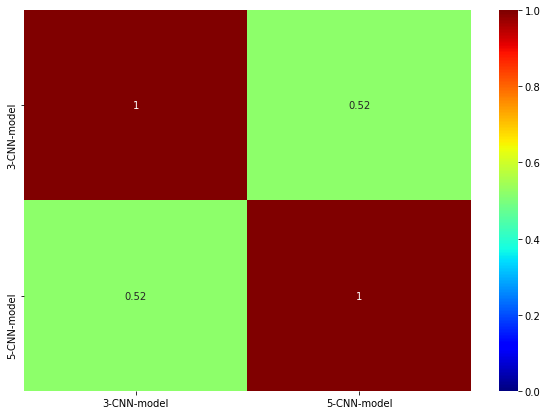

In [ ]:
#whole brain region activations dice similarity coeff wb model

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
lst = ['3-CNN-model','5-CNN-model']

array = [[1.0,0.5213384582183831], 
         [0.5213384582183831,1.0]]
df_cm = pd.DataFrame(array, index = [i for i in lst],
                  columns = [i for i in lst])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap='jet',vmin=0,vmax=1)